添加引用

In [36]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np


从Tesla数据集的视频中，得到训练图片。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [37]:
def img_pre_process(img, resize_w, resize_h):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
#    print("shape  ", shape)
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    ## Resize the image
    img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_AREA)
    ## Return the image sized as a 4D array
    return np.resize(img, (resize_w, resize_h, params.FLAGS.img_c))

In [38]:
from sklearn.model_selection import train_test_split

#加载epoch1到epoch9的所有视频的图片到img_list中，加载epoch1到epoch9的所有转向数据到steer_list，
def loadVideoAndResize(resize_w, resize_h):
    for epoch_id in range(1,11):    
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
        steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
        steer_data = utils.fetch_csv_data(steer_path)
    
        steer_list = steer_data['wheel'] 
    
        frame_count = utils.frame_count(vid_path)
        cap = cv2.VideoCapture(vid_path)
        img_list = []
    
        for frame_id in range(frame_count):
            ret, img = cap.read()       
            img_resized = img_pre_process(img, resize_w, resize_h)
            img_list.append(img_resized)
        
            if frame_id == frame_count - 1 and epoch_id == 9:
                print("img pre shape {}".format(img.shape))
                print("img after shape {}".format(img_resized.shape))
                plt.imshow(img)
                plt.show()
                plt.imshow(img_resized)
                plt.show()
    
   
    #把训练集存到本地
        train_add = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(epoch_id, resize_w,resize_h)
     #   val_add = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(epoch_id, resize_w,resize_h)
        pickle.dump((img_list, steer_list), open(train_add, 'wb'))
     #   pickle.dump((img_list_val, steer_list_val), open(val_add, 'wb'))





In [26]:
loadVideoAndResize(299, 299)

加载数据

In [39]:

def load_preprocess_training_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras import optimizers
seed = 10

In [41]:
def nor_output(pre_y):
    pre = pre_y.reshape(1, -1)[0]
    for i, x in enumerate(pre):
        pre[i] = round(x, 4)

    for i,x in enumerate(pre):
        if x > 0:
            if (x-math.floor(x))>=0.75:
                pre[i] = int(x) + 1.0
            elif (x-math.floor(x))>=0.25:
                pre[i] = (int(x) + 0.5)
            else:
                pre[i] = int(x)
        else:
            if (x-int(x))<=-0.75:
                pre[i] = int(x) - 1.0
            elif (x-int(x))<=-0.25:
                pre[i] = (int(x) - 0.5)
            else:
                pre[i] = int(x)
    return pre

In [20]:
def simple_model_1(time_len=1):
    ch, row, col = 3, 64, 64  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(256, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
#  model.add(Lambda(nor_output_1))
    sgd = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd)

      

    return model

In [150]:
def simple_model_2(time_len=1):
    ch, row, col = 3, 32, 32  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/255.0,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Conv2D(128,kernel_size =(3,3), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(256,kernel_size =(1,1), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(384,kernel_size =(9,9), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(512,kernel_size =(1,1), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Flatten())
      
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.6))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error', optimizer='sgd')

      

    return model

In [42]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def inceptionV3_model(time_len=1):
# create the base pre-trained model 299 * 299
    base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
    x = base_model.output
 #   x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
  #  x = Dense(1, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1)(x)

# this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#    model.compile(optimizer='sgd', loss='mean_absolute_error')

# train the model on the new data for a few epochs
    

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
 #   for i, layer in enumerate(base_model.layers):
 #       print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
   # from keras.optimizers import SGD
    model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='mean_absolute_error')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
   # model.fit_generator(...)
    return model

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def restNet_model(time_len=1):
    #224 * 224
    base_model = ResNet50(weights='imagenet')

    x = base_model.output
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='sgd', loss='mean_absolute_error')
  #  for i, layer in enumerate(base_model.layers):
     #   print(i, layer.name)
    return model

In [43]:
batch_size = 64
epoches = 20

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
from decimal import Decimal
def train_model(video_list, model_func, resize_w, resize_h, ifSave = False, test_img=None, test_y=None):
    model = model_func()
    ######
  #  for epoch_idx in range(1, (len(video_list) * epoches) + 1) :
  #      
  #      video_idx = epoch_idx % len(video_list)
  #      if video_idx == 0:
  #          video_idx = len(video_list)
  #      print("train epoch_idx {} video_idx{}".format(epoch_idx, video_idx))
  #      x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
  #      x_train = np.array(x_train).transpose(0, 2, 1, 3)
  #      model.fit(x_train, y_train, nb_epoch = 1, batch_size = batch_size)
    ######
  #  X = np.array([])
  #  Y = []
  #  for video_idx in range(1, len(video_list) + 1):
  #      x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
  #      x_train = np.array(x_train).transpose(0,  1, 2, 3)
  #      #其它是0321, interceptv3:0123
  #      if X.shape == np.array([]).shape:
  #          X = x_train
  #          Y = list(y_train)
  #      else:
  #          X = np.vstack((X, x_train))
  #          Y.extend(list(y_train))
  ########   
    
    val_acc = []
    test_acc = []
    for epoch_idx in range(0, epoches):
        
        x_val = np.array([])
        y_val = []
        for video_idx in range(1, len(video_list) + 1):
            x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
            x_train = np.array(x_train).transpose(0, 3, 2, 1)
            #随机打乱数据，取10%的训练数据做验证集
            img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(x_train, np.array(y_train), test_size=0.1, random_state=10) 
            model.fit(img_list_train, steer_list_train, nb_epoch = 1, batch_size = batch_size)
            if x_val.shape == np.array([]).shape:
                x_val = img_list_val
                y_val = list(steer_list_val)
            else:
                x_val = np.vstack((x_val, img_list_val))
                y_val.extend(list(steer_list_val))
        val_acc.append(test_model(model, x_val, y_val))
        if test_img != None:
            test_acc.append(test_model(model, test_img, test_y))
    if ifSave == True:
        utils.save_model(model)
        
    plt.plot(val_acc,color='b', label='验证准确率')
    plt.plot(test_acc, color='g', label='测试准确率')
    plt.show()
    return model

In [62]:
def test_model(model, img_list_val, y_val):
  #  pre = model.predict(img_list_val,  verbose=0)
    pre = model.predict(img_list_val)
    pre = nor_output(pre)
  #  print (pre)
    score = r2_score(y_val, pre)
    print("score: %.2f " % (score))
    

    if type(y_val) != np.array:
        y_val = np.array(y_val)
    y_val = y_val.reshape(len(list(y_val)), 1)    
    y_val = y_val.reshape(1, -1)[0]
    x = np.arange(1, len(y_val) + 1)
    y = y_val  - pre ;

    plt.plot(x, abs(y) , marker = '.', color = 'b', label = 'steer bias',linewidth=0.1)
    plt.show()
    return score

训练单个视频

In [46]:
res_w = 299
res_h = 299
x_test, y_test = load_preprocess_training_batch(10, res_w, res_h)   
x_test = np.array(x_test).transpose(0, 3, 2, 1)

In [16]:
#img_val, steer_val = load_preprocess_validating_batch(1, res_w, res_h)
#img_val = np.array(img_val).transpose(0, 3, 2, 1)

model_single = train_model([1],  inceptionV3_model, res_w, res_h, ifSave = True)
test_model(model_single, x_test, y_test)

/Users/apple/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5


/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/5


KeyboardInterrupt: 

训练全部视频

/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same", strides=(2, 2))`
  
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", strides=(2, 2))`
  if sys.path[0] == '':
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), padding="same", strides=(2, 2))`
  
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/keras/models.

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.6861
Epoch 1/1
3510/3510 [==============================] - 16s 5ms/step - loss: 1.3998
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.5669
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 7.5214
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.8665
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.4184
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 2.5157
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.3699
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4653
score: -0.00 


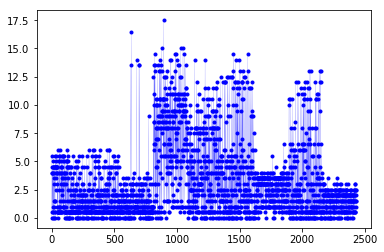

/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:51: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


score: -0.74 


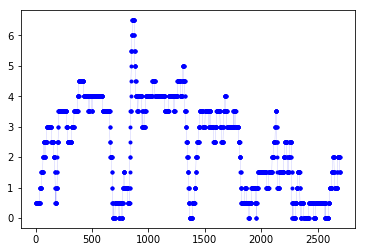

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.7083
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.4184
Epoch 1/1
2430/2430 [==============================] - 13s 5ms/step - loss: 1.5520
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 7.5184
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 3.8136
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 4.4215
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 2.4915
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.3614
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.4203
score: -0.00 


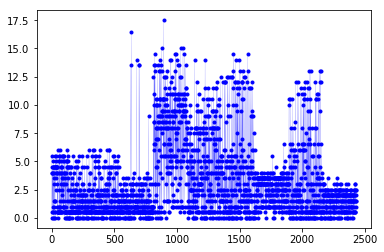

score: -0.74 


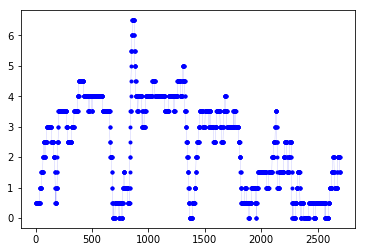

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.7125
Epoch 1/1
3510/3510 [==============================] - 16s 5ms/step - loss: 1.4163
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 1.5382
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 7.5098
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.8121
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 4.4153
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 2.4704
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 3.3456
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.3789
score: 0.01 


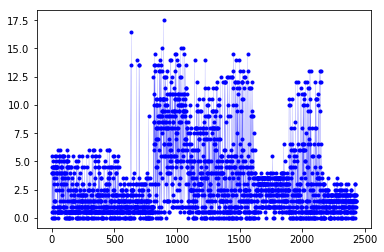

score: -0.40 


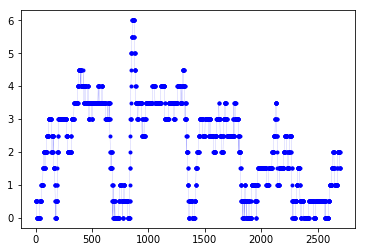

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.7077
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.4052
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.5173
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 7.4920
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 3.8269
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.3996
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 2.4373
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.3194
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.3146
score: 0.03 


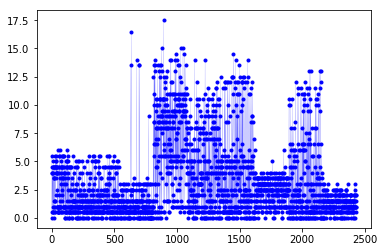

score: -0.38 


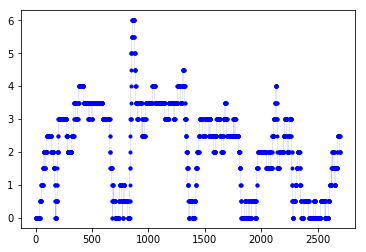

Epoch 1/1
1350/1350 [==============================] - 6s 5ms/step - loss: 2.6967
Epoch 1/1
3510/3510 [==============================] - 17s 5ms/step - loss: 1.3879
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.4880
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 7.4712
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 3.8119
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 4.4007
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.3731
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.2816
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 1.2048
score: 0.04 


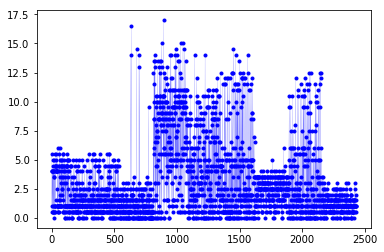

score: -0.15 


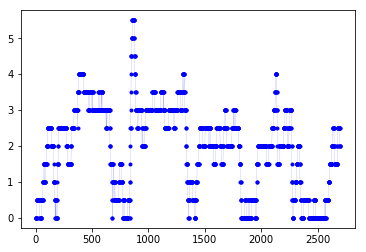

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.6740
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.3761
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4663
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 7.4301
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.7394
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 4.3986
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.2808
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.2219
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0907
score: 0.07 


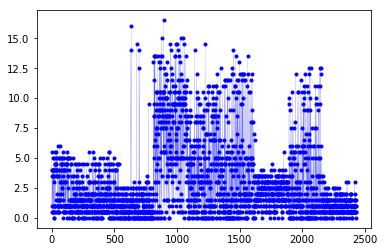

score: 0.07 


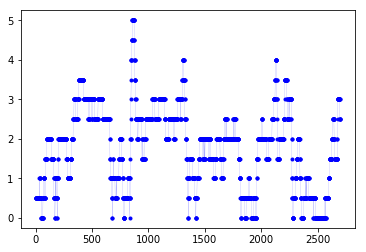

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.5961
Epoch 1/1
3510/3510 [==============================] - 15s 4ms/step - loss: 1.3683
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.4561
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 7.3678
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 3.6320
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 4.4320
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 2.1423
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1430
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 0.9590
score: 0.10 


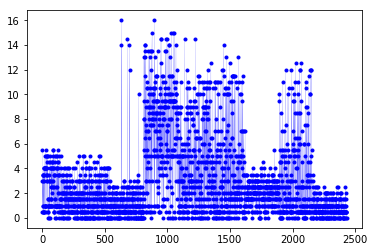

score: 0.26 


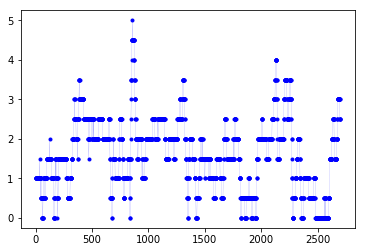

Epoch 1/1
1350/1350 [==============================] - 7s 5ms/step - loss: 2.4478
Epoch 1/1
3510/3510 [==============================] - 15s 4ms/step - loss: 1.3636
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.4673
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 7.2844
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.4866
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 4.4871
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.9699
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 3.0496
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 0.9024
score: 0.11 


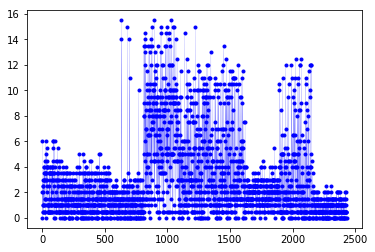

score: 0.37 


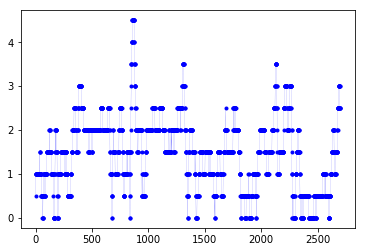

Epoch 1/1
1350/1350 [==============================] - 6s 5ms/step - loss: 2.2717
Epoch 1/1
3510/3510 [==============================] - 15s 4ms/step - loss: 1.3529
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4683
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 7.1911
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.3076
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.5565
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.8240
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 2.9851
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 0.9026
score: 0.12 


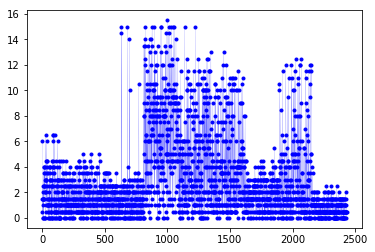

score: 0.44 


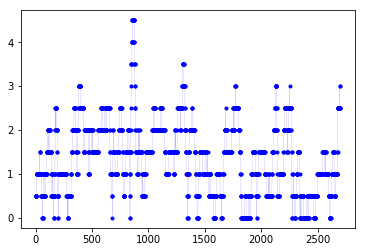

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.1478
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.3587
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4707
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 7.0920
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 3.2484
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.5721
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.7137
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.9561
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 0.9295
score: 0.13 


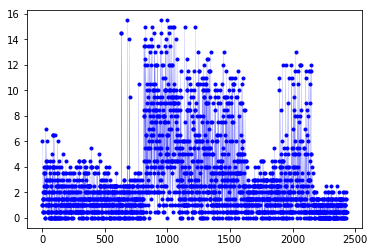

score: 0.46 


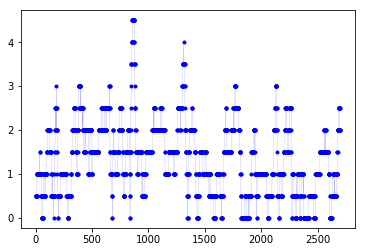

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.1084
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.3472
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4657
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 6.9980
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.2125
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.5613
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.6403
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 2.9398
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 0.9535
score: 0.13 


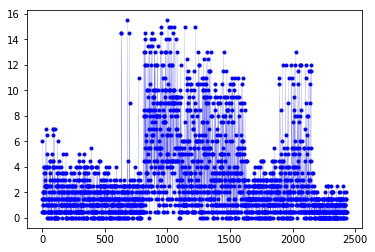

score: 0.48 


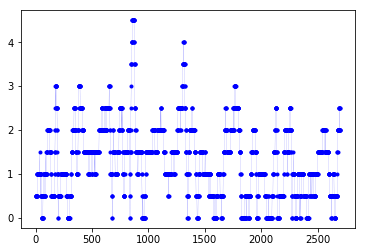

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.0663
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.3162
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4501
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 6.8917
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1770
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.5399
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.5570
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.8925
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 0.9985
score: 0.14 


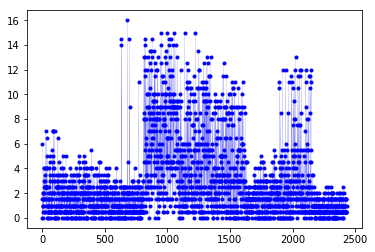

score: 0.51 


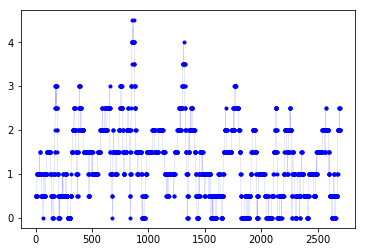

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.0562
Epoch 1/1
3510/3510 [==============================] - 15s 4ms/step - loss: 1.2861
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4402
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 6.7955
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1262
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.5226
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4943
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.8819
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0032
score: 0.15 


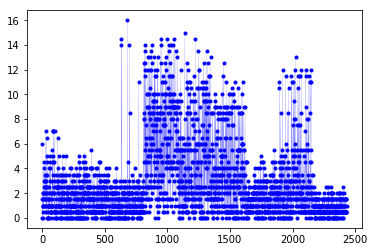

score: 0.48 


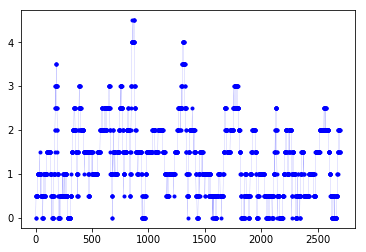

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.0664
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.2513
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 1.4002
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 6.6991
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1398
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.4604
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.4267
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.8415
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0199
score: 0.17 


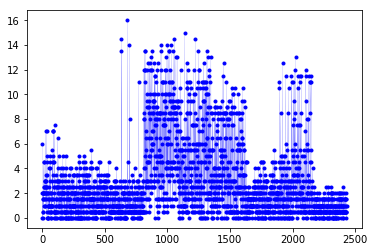

score: 0.49 


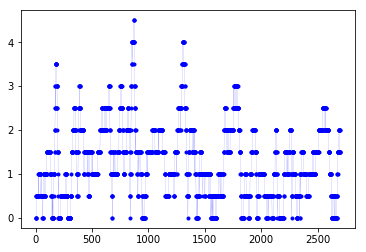

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.0587
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.2115
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.3713
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 6.5749
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1384
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.3931
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.3600
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 2.8024
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0416
score: 0.18 


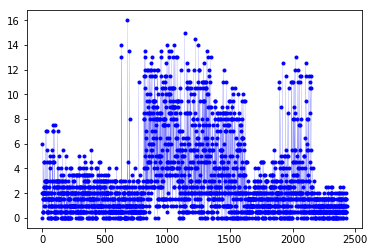

score: 0.45 


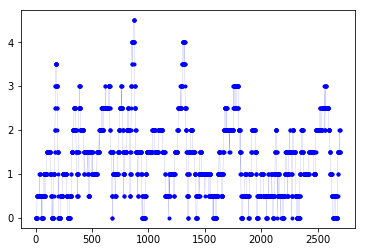

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.0958
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.1720
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.3347
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 6.4414
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1470
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.3198
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.2934
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 2.7775
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0342
score: 0.21 


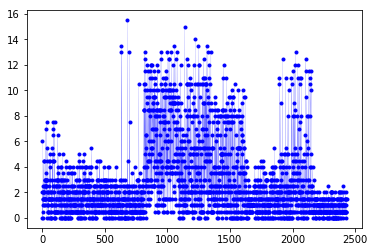

score: 0.46 


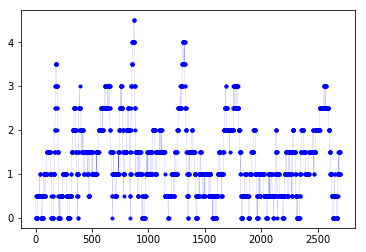

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.1097
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.1196
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.2936
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 6.3170
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1580
Epoch 1/1
2430/2430 [==============================] - 14s 6ms/step - loss: 4.2005
Epoch 1/1
2430/2430 [==============================] - 12s 5ms/step - loss: 1.2464
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 2.7142
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0205
score: 0.24 


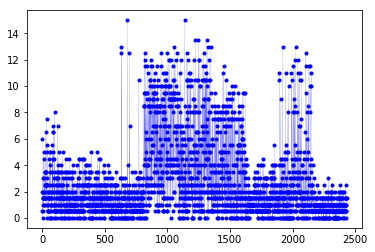

score: 0.41 


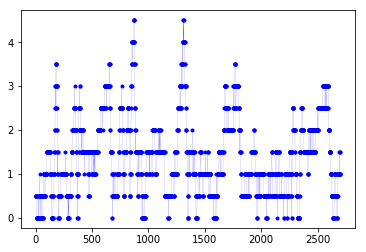

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.1193
Epoch 1/1
3510/3510 [==============================] - 15s 4ms/step - loss: 1.0909
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.2657
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 6.1267
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1720
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 4.1142
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 1.2176
Epoch 1/1
2430/2430 [==============================] - 11s 5ms/step - loss: 2.6535
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.0341
score: 0.27 


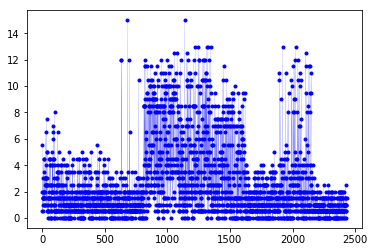

score: 0.41 


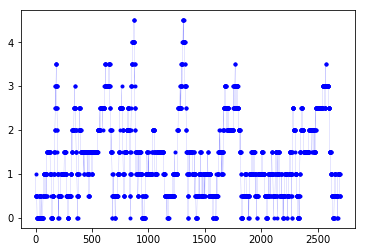

Epoch 1/1
1350/1350 [==============================] - 6s 4ms/step - loss: 2.1433
Epoch 1/1
3510/3510 [==============================] - 15s 4ms/step - loss: 1.0860
Epoch 1/1
2430/2430 [==============================] - 11s 4ms/step - loss: 1.2270
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 5.9413
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.1894
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 4.0274
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.2292
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 2.5891
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0290
score: 0.29 


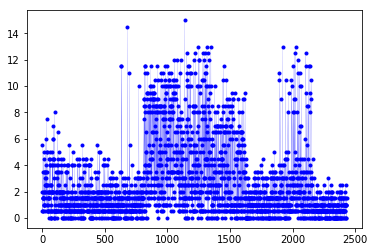

score: 0.34 


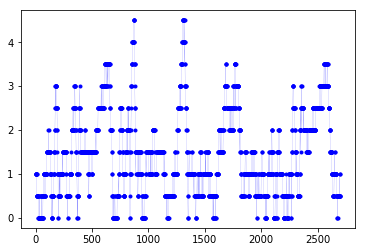

Epoch 1/1
1350/1350 [==============================] - 5s 4ms/step - loss: 2.1641
Epoch 1/1
3510/3510 [==============================] - 14s 4ms/step - loss: 1.0704
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.2258
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 5.7901
Epoch 1/1
2430/2430 [==============================] - 9s 4ms/step - loss: 3.1926
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 3.9085
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.2192
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 2.5059
Epoch 1/1
2430/2430 [==============================] - 10s 4ms/step - loss: 1.0573
score: 0.30 


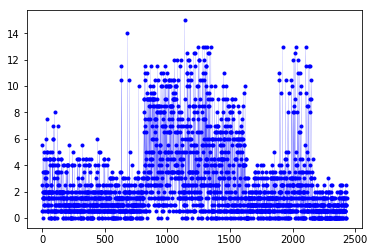

score: 0.28 


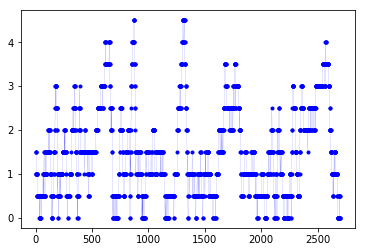

Model saved


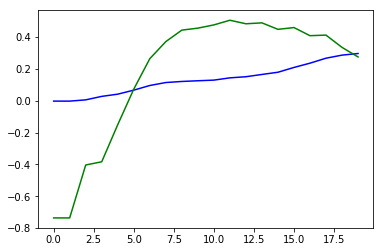

score: 0.28 


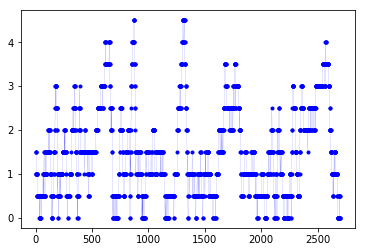

0.27526276018410378

In [21]:
model_all = train_model(range(1, 10),  simple_model_1, res_w, res_h, ifSave = True, test_img = x_test, test_y = y_test)
test_model(model_all, x_test, y_test)

semi-superviser

In [47]:
def inception_v3_semi_super_model():
    base_model = InceptionV3(weights='imagenet', include_top=True)
    model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
    return model

In [53]:
def get_featurn_h5_path(video_idx):
    return utils.join_dir(params.data_dir, 'epoch{:0>2}_feature.h5').format(video_idx)
def get_y_h5_path(video_idx):
    return utils.join_dir(params.data_dir, 'epoch{:0>2}_y.h5').format(video_idx)
def save_feature_and_y_h5(model, video_list):
    for v_idx in video_list:
        features = []
        x_test, y_test = load_preprocess_training_batch(v_idx, res_w, res_h)   
        x_test = np.array(x_test).transpose(0, 1, 2, 3)
        for x in x_test:            
            x = np.expand_dims(x, axis=0)
          #  print (x)
         #   x = preprocess_input(x)
         #   x /= 127.5
         #   x -= 1.
            feature = model.predict(x)
            flat = feature.flatten()
            if v_idx== 1:
                print(flat)
            features.append(flat)
            
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_feature.h5').format(v_idx)
        y_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_y.h5').format(v_idx)

        h5f_data = h5py.File(vid_path, 'w')
        h5f_data.create_dataset('dataset_1', data=np.array(features))
        h5f_data.close()
        
        h5y_data = h5py.File(y_path, 'w')
        h5y_data.create_dataset('dataset_1', data=np.array(y_test))
        h5y_data.close()
        print(vid_path)
        
def get_feature_and_y(video_idx):
    h5f_data  = h5py.File(get_featurn_h5_path(video_idx), 'r')
    h5f_y = h5py.File(get_y_h5_path(video_idx), 'r')

    features = h5f_data['dataset_1']
    ys = h5f_y['dataset_1']

    features = np.array(features)
    ys   = np.array(ys)

    h5f_data.close()
    h5f_y.close()
    return features, ys

In [64]:
import h5py
from sklearn import tree
def train_semi_super_model(video_list, cnn_model_func, resize_w, resize_h, ifSave = False, test_video=None, if_save_feature=True):
    cnn_model = cnn_model_func()
    if if_save_feature == True:
        save_feature_and_y_h5(cnn_model, video_list)
        if test_video != None:
            save_feature_and_y_h5(cnn_model, [test_video])
    
    val_acc = []
    test_acc = []
    regressor = tree.DecisionTreeRegressor(max_depth = 5)
    for epoch_idx in range(0, epoches):
        
        x_val = np.array([])
        y_val = []
        for video_idx in range(1, len(video_list) + 1):
            
            features, ys = get_feature_and_y(video_idx)
            
            #随机打乱数据，取10%的训练数据做验证集
            f_list_train, f_list_val, steer_list_train, steer_list_val = train_test_split(features, np.array(ys), test_size=0.1, random_state=10) 
            regressor.fit(f_list_train, steer_list_train)
            if x_val.shape == np.array([]).shape:
                x_val = f_list_val
                y_val = list(steer_list_val)
            else:
                x_val = np.vstack((x_val, f_list_val))
                y_val.extend(list(steer_list_val))
        val_acc.append(test_model(regressor, x_val, y_val))
        if test_video != None:
            test_features, test_ys = get_feature_and_y(test_video)
            test_acc.append(test_model(regressor, test_features, test_ys))
    if ifSave == True:
        utils.save_model(regressor)
        
    plt.plot(val_acc,color='b', label='验证准确率')
    plt.plot(test_acc, color='g', label='测试准确率')
    plt.show()
    return model

/Users/apple/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5


/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  This is separate from the ipykernel package so we can avoid doing imports until


score: -0.02 


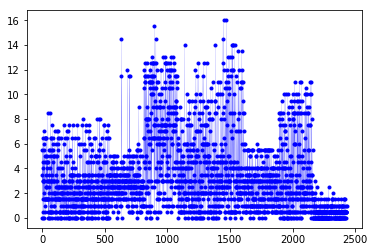

score: -0.15 


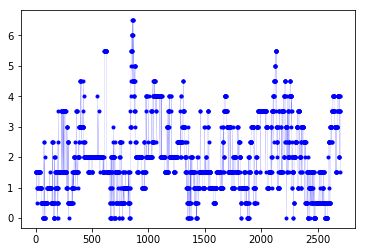

In [ ]:
train_semi_super_model(range(1, 10),  inception_v3_semi_super_model, res_w, res_h, ifSave = True, test_video = 10,if_save_feature=False)
